In [1]:
import os
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

import numpy as np

# ============================================================
# 1. PATHS – ADAPT THIS PART TO YOUR KAGGLE DATASET NAME
# ============================================================

# In Kaggle, check this first in a cell:
#   !ls /kaggle/input
#
# Then set ROOT_DIR accordingly, e.g.:
#   /kaggle/input/fruits-360/Training
# Sometimes it’s nested one level deeper; adjust if needed.

ROOT_DIR = Path("/kaggle/input/fruits/fruits-360_100x100/fruits-360")
TRAIN_DIR = ROOT_DIR / "Training"
TEST_DIR  = ROOT_DIR / "Test"

print("Train dir:", TRAIN_DIR)
print("Test dir :", TEST_DIR)

# ============================================================
# 2. BASIC CONFIG
# ============================================================

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS_STAGE1 = 15   # frozen base
EPOCHS_STAGE2 = 10   # fine-tuning

AUTOTUNE = tf.data.AUTOTUNE

# ============================================================
# 3. DATASET PIPELINES (Train / Val split from Training)
# ============================================================

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,   # 80% train, 20% val
    subset="training",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="validation",
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Number of classes:", num_classes)
print("Example classes:", class_names[:10])

# Improve performance with prefetch
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# ============================================================
# 4. DATA AUGMENTATION
# ============================================================

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ],
    name="data_augmentation",
)

# ============================================================
# 5. BUILD MODEL – EfficientNetB0 + Transfer Learning
# ============================================================

def build_model(img_size=IMG_SIZE, num_classes=10):
    inputs = keras.Input(shape=img_size + (3,), name="input_image")

    # 1) Data augmentation
    x = data_augmentation(inputs)

    # 2) Preprocessing for EfficientNet
    x = layers.Lambda(preprocess_input, name="preprocessing")(x)

    # 3) Base model (pretrained on ImageNet)
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=x,
    )

    base_model.trainable = False  # Stage 1: frozen

    # 4) Global pooling + head
    x = base_model.output
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.Dropout(0.3, name="dropout")(x)

    outputs = layers.Dense(
        num_classes,
        activation="softmax",
        name="predictions",
    )(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="fruits360_efficientnetb0")
    return model


model = build_model(IMG_SIZE, num_classes)
model.summary()

# ============================================================
# 6. COMPILE (STAGE 1 – FROZEN BASE)
# ============================================================

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# ============================================================
# 7. CALLBACKS
# ============================================================

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_fruits360_efficientnetb0.keras"),
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
)

earlystop_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)

# ============================================================
# 8. TRAIN – STAGE 1 (FROZEN BASE)
# ============================================================

history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
)



2025-12-03 04:33:40.349765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764736420.796704      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764736420.937001      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Train dir: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training
Test dir : /kaggle/input/fruits/fruits-360_100x100/fruits-360/Test
Found 119950 files belonging to 228 classes.
Using 95960 files for training.


I0000 00:00:1764736564.293904      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764736564.294636      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 119950 files belonging to 228 classes.
Using 23990 files for validation.
Found 39999 files belonging to 228 classes.
Number of classes: 228
Example classes: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "fruits360_efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_image[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocessing       │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ preprocessing[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc

 Total params: 4,341,639 (16.56 MB)

 Trainable params: 292,068 (1.11 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/15


E0000 00:00:1764736652.128025      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/fruits360_efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1764736654.991287     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


2999/2999 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7711 - loss: 1.3539
Epoch 1: val_accuracy improved from -inf to 0.98904, saving model to checkpoints/best_fruits360_efficientnetb0.keras
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 304s 97ms/step - accuracy: 0.7712 - loss: 1.3536 - val_accuracy: 0.9890 - val_loss: 0.0778 - learning_rate: 0.0010
Epoch 2/15
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9844 - loss: 0.0966
Epoch 2: val_accuracy improved from 0.98904 to 0.99446, saving model to checkpoints/best_fruits360_efficientnetb0.keras
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 292s 97ms/step - accuracy: 0.9844 - loss: 0.0966 - val_accuracy: 0.9945 - val_loss: 0.0342 - learning_rate: 0.0010
Epoch 3/15
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9911 - loss: 0.0497
Epoch 3: val_accuracy improved from 0.99446 to 0.99621, saving model to checkpoints/best_fruits360_efficientnetb0.keras
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 289s 96ms/step - accuracy: 0.9911 - loss: 0.0497 - val_accuracy:

ValueError: No such layer: efficientnetb0. Existing layers are: ['input_image', 'data_augmentation', 'preprocessing', 'rescaling', 'normalization', 'rescaling_1', 'stem_conv_pad', 'stem_conv', 'stem_bn', 'stem_activation', 'block1a_dwconv', 'block1a_bn', 'block1a_activation', 'block1a_se_squeeze', 'block1a_se_reshape', 'block1a_se_reduce', 'block1a_se_expand', 'block1a_se_excite', 'block1a_project_conv', 'block1a_project_bn', 'block2a_expand_conv', 'block2a_expand_bn', 'block2a_expand_activation', 'block2a_dwconv_pad', 'block2a_dwconv', 'block2a_bn', 'block2a_activation', 'block2a_se_squeeze', 'block2a_se_reshape', 'block2a_se_reduce', 'block2a_se_expand', 'block2a_se_excite', 'block2a_project_conv', 'block2a_project_bn', 'block2b_expand_conv', 'block2b_expand_bn', 'block2b_expand_activation', 'block2b_dwconv', 'block2b_bn', 'block2b_activation', 'block2b_se_squeeze', 'block2b_se_reshape', 'block2b_se_reduce', 'block2b_se_expand', 'block2b_se_excite', 'block2b_project_conv', 'block2b_project_bn', 'block2b_drop', 'block2b_add', 'block3a_expand_conv', 'block3a_expand_bn', 'block3a_expand_activation', 'block3a_dwconv_pad', 'block3a_dwconv', 'block3a_bn', 'block3a_activation', 'block3a_se_squeeze', 'block3a_se_reshape', 'block3a_se_reduce', 'block3a_se_expand', 'block3a_se_excite', 'block3a_project_conv', 'block3a_project_bn', 'block3b_expand_conv', 'block3b_expand_bn', 'block3b_expand_activation', 'block3b_dwconv', 'block3b_bn', 'block3b_activation', 'block3b_se_squeeze', 'block3b_se_reshape', 'block3b_se_reduce', 'block3b_se_expand', 'block3b_se_excite', 'block3b_project_conv', 'block3b_project_bn', 'block3b_drop', 'block3b_add', 'block4a_expand_conv', 'block4a_expand_bn', 'block4a_expand_activation', 'block4a_dwconv_pad', 'block4a_dwconv', 'block4a_bn', 'block4a_activation', 'block4a_se_squeeze', 'block4a_se_reshape', 'block4a_se_reduce', 'block4a_se_expand', 'block4a_se_excite', 'block4a_project_conv', 'block4a_project_bn', 'block4b_expand_conv', 'block4b_expand_bn', 'block4b_expand_activation', 'block4b_dwconv', 'block4b_bn', 'block4b_activation', 'block4b_se_squeeze', 'block4b_se_reshape', 'block4b_se_reduce', 'block4b_se_expand', 'block4b_se_excite', 'block4b_project_conv', 'block4b_project_bn', 'block4b_drop', 'block4b_add', 'block4c_expand_conv', 'block4c_expand_bn', 'block4c_expand_activation', 'block4c_dwconv', 'block4c_bn', 'block4c_activation', 'block4c_se_squeeze', 'block4c_se_reshape', 'block4c_se_reduce', 'block4c_se_expand', 'block4c_se_excite', 'block4c_project_conv', 'block4c_project_bn', 'block4c_drop', 'block4c_add', 'block5a_expand_conv', 'block5a_expand_bn', 'block5a_expand_activation', 'block5a_dwconv', 'block5a_bn', 'block5a_activation', 'block5a_se_squeeze', 'block5a_se_reshape', 'block5a_se_reduce', 'block5a_se_expand', 'block5a_se_excite', 'block5a_project_conv', 'block5a_project_bn', 'block5b_expand_conv', 'block5b_expand_bn', 'block5b_expand_activation', 'block5b_dwconv', 'block5b_bn', 'block5b_activation', 'block5b_se_squeeze', 'block5b_se_reshape', 'block5b_se_reduce', 'block5b_se_expand', 'block5b_se_excite', 'block5b_project_conv', 'block5b_project_bn', 'block5b_drop', 'block5b_add', 'block5c_expand_conv', 'block5c_expand_bn', 'block5c_expand_activation', 'block5c_dwconv', 'block5c_bn', 'block5c_activation', 'block5c_se_squeeze', 'block5c_se_reshape', 'block5c_se_reduce', 'block5c_se_expand', 'block5c_se_excite', 'block5c_project_conv', 'block5c_project_bn', 'block5c_drop', 'block5c_add', 'block6a_expand_conv', 'block6a_expand_bn', 'block6a_expand_activation', 'block6a_dwconv_pad', 'block6a_dwconv', 'block6a_bn', 'block6a_activation', 'block6a_se_squeeze', 'block6a_se_reshape', 'block6a_se_reduce', 'block6a_se_expand', 'block6a_se_excite', 'block6a_project_conv', 'block6a_project_bn', 'block6b_expand_conv', 'block6b_expand_bn', 'block6b_expand_activation', 'block6b_dwconv', 'block6b_bn', 'block6b_activation', 'block6b_se_squeeze', 'block6b_se_reshape', 'block6b_se_reduce', 'block6b_se_expand', 'block6b_se_excite', 'block6b_project_conv', 'block6b_project_bn', 'block6b_drop', 'block6b_add', 'block6c_expand_conv', 'block6c_expand_bn', 'block6c_expand_activation', 'block6c_dwconv', 'block6c_bn', 'block6c_activation', 'block6c_se_squeeze', 'block6c_se_reshape', 'block6c_se_reduce', 'block6c_se_expand', 'block6c_se_excite', 'block6c_project_conv', 'block6c_project_bn', 'block6c_drop', 'block6c_add', 'block6d_expand_conv', 'block6d_expand_bn', 'block6d_expand_activation', 'block6d_dwconv', 'block6d_bn', 'block6d_activation', 'block6d_se_squeeze', 'block6d_se_reshape', 'block6d_se_reduce', 'block6d_se_expand', 'block6d_se_excite', 'block6d_project_conv', 'block6d_project_bn', 'block6d_drop', 'block6d_add', 'block7a_expand_conv', 'block7a_expand_bn', 'block7a_expand_activation', 'block7a_dwconv', 'block7a_bn', 'block7a_activation', 'block7a_se_squeeze', 'block7a_se_reshape', 'block7a_se_reduce', 'block7a_se_expand', 'block7a_se_excite', 'block7a_project_conv', 'block7a_project_bn', 'top_conv', 'top_bn', 'top_activation', 'avg_pool', 'dropout', 'predictions'].

In [4]:
def extract_backbone(model):
    first = next(i for i,l in enumerate(model.layers) if l.name.startswith("block1a"))
    last  = next(i for i,l in reversed(list(enumerate(model.layers))) if l.name=="top_activation")

    inputs = model.layers[first].input
    outputs = model.layers[last].output

    return keras.Model(inputs, outputs, name="efficientnet_backbone")


Model: "efficientnet_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_15CLO… │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ keras_tensor_15C… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[1… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[1][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 112, 112,  │      1,536 │ block1a_project_… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 112, 112,  │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 112, 112,  │          0 │ block2a_expand_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_dwconv_pad  │ (None, 113, 113,  │          0 │ block2a_expand_a… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_dwconv      │ (None, 56, 56,    │        864 │ block2a_dwconv_p… │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_bn          │ (None, 56, 56,    │        384 │ block2a_dwconv[1

 Total params: 4,048,572 (15.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,048,572 (15.44 MB)

Total layers in base model: 231
Fine-tuning from layer index: 138
Epoch 14/25


E0000 00:00:1764742639.430859      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/fruits360_efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2999/2999 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9954 - loss: 0.0167
Epoch 14: val_accuracy improved from 0.99904 to 0.99925, saving model to checkpoints/best_fruits360_efficientnetb0.keras
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 297s 96ms/step - accuracy: 0.9954 - loss: 0.0167 - val_accuracy: 0.9992 - val_loss: 0.0046 - learning_rate: 1.0000e-05
Epoch 15/25
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9960 - loss: 0.0150
Epoch 15: val_accuracy did not improve from 0.99925
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 288s 96ms/step - accuracy: 0.9960 - loss: 0.0150 - val_accuracy: 0.9992 - val_loss: 0.0045 - learning_rate: 1.0000e-05
Epoch 16/25
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9961 - loss: 0.0144
Epoch 16: val_accuracy improved from 0.99925 to 0.99929, saving model to checkpoints/best_fruits360_efficientnetb0.keras
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 290s 97ms/step - accuracy: 0.9961 - loss: 0.0144 - val_accuracy: 0.9993 - val_loss: 0.0044 - learning_rate: 1.0000e-0

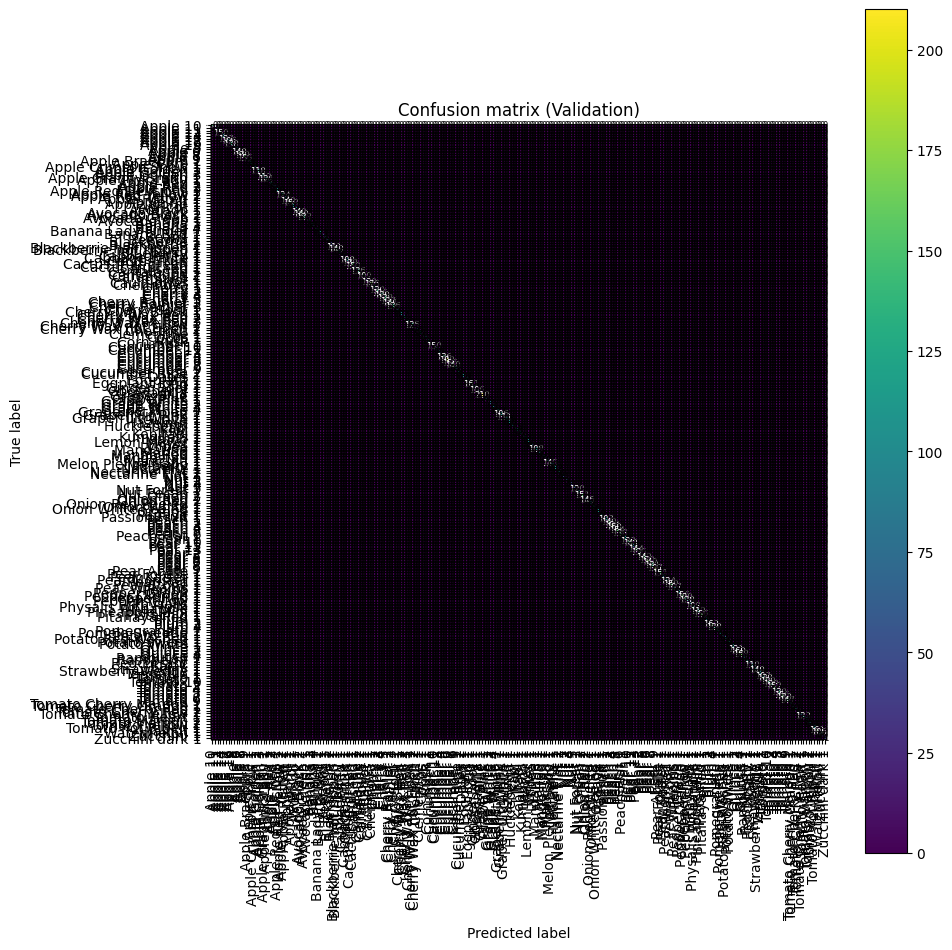

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Sample 0:
  True : Apple 10
  Pred : Apple 10
Sample 1:
  True : Apple 10
  Pred : Apple 10
Sample 2:
  True : Apple 10
  Pred : Apple 10
Sample 3:
  True : Apple 10
  Pred : Apple 10
Sample 4:
  True : Apple 10
  Pred : Apple 10


In [5]:
# ============================================================
# 9. FINE-TUNE – STAGE 2 (UNFREEZE TOP OF BASE MODEL)
# ============================================================
base_model = extract_backbone(model)
base_model.summary()

base_model.trainable = True

# Freeze bottom ~60% of layers, fine-tune top ~40%
fine_tune_at = int(len(base_model.layers) * 0.6)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print("Total layers in base model:", len(base_model.layers))
print("Fine-tuning from layer index:", fine_tune_at)

# Re-compile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1 + EPOCHS_STAGE2,
    initial_epoch=len(history_stage1.history["loss"]),
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
)

# ============================================================
# 10. EVALUATION – VAL + TEST
# ============================================================

print("Evaluating on validation set:")
val_loss, val_acc = model.evaluate(val_ds)
print(f"Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}")

print("Evaluating on test set:")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

# ============================================================
# 11. CONFUSION MATRIX + CLASSIFICATION REPORT (OPTIONAL)
# ============================================================

try:
    from sklearn.metrics import confusion_matrix, classification_report
    import matplotlib.pyplot as plt
    import itertools

    def get_labels_and_preds(dataset, model):
        y_true = []
        y_pred = []
        for images, labels in dataset:
            preds = model.predict(images, verbose=0)
            y_true.extend(np.argmax(labels.numpy(), axis=1))
            y_pred.extend(np.argmax(preds, axis=1))
        return np.array(y_true), np.array(y_pred)

    y_true_val, y_pred_val = get_labels_and_preds(val_ds, model)

    cm = confusion_matrix(y_true_val, y_pred_val)
    print("\nClassification report (VAL):")
    print(classification_report(y_true_val, y_pred_val, target_names=class_names))

    def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix"):
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(10, 10))
        plt.imshow(cm, interpolation="nearest")
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90)
        plt.yticks(tick_marks, classes)

        fmt = ".2f" if normalize else "d"
        thresh = cm.max() / 2.0
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(
                j,
                i,
                format(cm[i, j], fmt),
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=6,
            )

        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.tight_layout()
        plt.show()

    plot_confusion_matrix(cm, classes=class_names, normalize=False,
                          title="Confusion matrix (Validation)")

except ImportError:
    print("Install scikit-learn and matplotlib to get confusion matrix + report.")

# ============================================================
# 12. EXAMPLE PREDICTION ON ONE TEST BATCH (OPTIONAL)
# ============================================================

for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_idxs = np.argmax(preds, axis=1)
    true_idxs = np.argmax(labels.numpy(), axis=1)

    for i in range(5):
        print(f"Sample {i}:")
        print("  True :", class_names[true_idxs[i]])
        print("  Pred :", class_names[pred_idxs[i]])
    break
